In [1]:
import pandas as pd
import pickle
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from scipy.stats import pearsonr
from statsmodels.stats.multitest import fdrcorrection
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D 

In [2]:
phenotypes_mb = pd.read_pickle('/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/phenotypes_mb.pkl')

with open('/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/target_phenotypes.pkl', 'rb') as f:
    target_phenotypes = pickle.load(f)

phenotypes_mb

,RegistrationCode,age,sex,vat_fat_ratio,android/gynoid ratio,fat_mass_index,waist_hips_ratio,waist_height_ratio,mean_hand_grip,ALM,...,Alistipes avistercoris,Alistipes dispar,Tidjanibacter inops,Oxalobacter aliiformigenes,Oxalobacter formigenes,Duodenibacillus sp900544335,Aphodousia faecalis,Parasutterella gallistercoris,Parasutterella excrementihominis,Mesosutterella multiformis
0,10K_1000942861,0.375867,1.0,0.056535,1.309820,7.462508,0.925234,0.548476,131.349998,30.758968,...,7.009843,7.563322,4.652684,6.635850,12.012584,8.688301,10.365971,9.255033,4.138850,6.419551
1,10K_1001201093,-1.189224,0.0,0.021434,0.734188,6.268973,0.783505,0.447059,67.349998,17.051393,...,7.009843,4.725922,4.652684,6.635850,12.012584,8.688301,10.365971,9.255033,4.138850,6.419551
2,10K_1002254441,-0.797952,1.0,0.055767,1.174556,6.893385,0.947368,0.505618,86.250000,21.831000,...,7.009843,4.725922,4.652684,10.787403,12.012584,8.688301,10.365971,9.255033,7.956086,6.419551
3,10K_1003113258,-0.276254,1.0,NaN,NaN,NaN,NaN,NaN,102.850002,NaN,...,7.009843,5.927581,4.652684,8.667175,12.012584,8.688301,10.365971,9.255033,4.595218,6.419551
4,10K_1007330152,1.549686,1.0,NaN,1.595805,14.307040,1.035714,NaN,97.450001,25.144313,...,7.009843,4.725922,8.111075,6.635850,12.012584,8.688301,10.365971,9.255033,9.010128,10.112833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10059,10K_6595065879,0.245443,0.0,0.004003,0.641055,NaN,NaN,NaN,NaN,12.496091,...,7.009843,5.763687,4.652684,6.635850,12.012584,8.688301,10.365971,9.255033,4.834536,6.419551
10060,10K_1439720299,-0.015406,1.0,0.041723,1.154418,NaN,NaN,NaN,NaN,22.371791,...,7.009843,8.242829,6.564945,6.635850,12.012584,8.688301,10.365971,9.255033,5.494743,6.419551
10061,10K_4637431621,0.767140,0.0,0.037967,0.913265,NaN,NaN,NaN,NaN,15.591000,...,7.009843,4.725922,4.652684,6.635850,12.012584,8.688301,10.365971,9.255033,4.138850,6.419551
10062,10K_9999226141,-1.319649,1.0,0.052698,1.429954,NaN,NaN,NaN,NaN,24.904157,...,7.009843,4.725922,4.652684,9.536412,12.012584,8.688301,10.365971,9.255033,4.138850,6.419551


In [3]:
target_phenotypes

[['vat_fat_ratio',
  'android/gynoid ratio',
  'fat_mass_index',
  'waist_hips_ratio',
  'waist_height_ratio',
  'mean_hand_grip',
  'ALM',
  'ALMI',
  'ALM_BMI',
  'sitting_systolic_bp_mean',
  'sitting_diastolic_bp_mean',
  'pulse_pressure',
  'mean_arterial_pressure',
  'total_scan_vat_mass'],
 ['liver_sound_speed_mps'],
 ['AHI', 'ODI', 'RDI'],
 ['bt__urea',
  'bt__wbc',
  'bt__glucose',
  'bt__mcv',
  'bt__hemoglobin',
  'bt__uric_acid',
  'bt__total_cholesterol',
  'bt__triglycerides',
  'bt__non_hdl_cholesterol',
  'triglyceride_to_hdl_ratio',
  'bt__ldl_cholesterol',
  'bt__hdl_cholesterol']]

In [4]:
phenotypes_mb['bt__wbc'].describe()

count    5902.000000
mean        6.302597
std         1.402877
min         2.300000
25%         5.300000
50%         6.200000
75%         7.200000
max        10.300000
Name: bt__wbc, dtype: float64

##### DELETE

In [5]:
from collections import Counter, defaultdict

def rename_microbiome_columns(df: pd.DataFrame, mb_names: pd.DataFrame) -> pd.DataFrame:
    """
    Get either microbial_features (from diet_mb) or gut_bacteria_df (from the loader)
    """
    # --- Normalize ---
    mb_names.index = mb_names.index.str.strip()
    df = df.copy()
    df.columns = df.columns.str.strip()

    # --- Extract maps ---
    species_map = mb_names['species_new'].str.strip()
    genus_map = mb_names['genus_new'].str.strip()
    family_map = mb_names['family_new'].str.strip()

    # --- Build name mapping ---
    final_mapping = {}
    for col in df.columns[1:]:  # Skip RegistrationCode or first identifier column
        name = species_map.get(col, None)
        if name == "unknown" or pd.isna(name):
            name = genus_map.get(col, None)
        if name == "unknown" or pd.isna(name):
            name = family_map.get(col, None)
        if name is None or name == "unknown":
            name = col  # fallback
        final_mapping[col] = name

    # --- Rename columns ---
    df.rename(columns=final_mapping, inplace=True)

    # --- Deduplicate ---
    col_counts = Counter(df.columns)
    name_counter = defaultdict(int)
    new_cols = []

    for col in df.columns:
        if col_counts[col] > 1:
            name_counter[col] += 1
            new_cols.append(f"{col}_{name_counter[col]}")
        else:
            new_cols.append(col)

    df.columns = new_cols

    return df


In [7]:
# diet_mb = pd.read_pickle(f"/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/segal_species/diet_mb.pkl")
# with open('/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/segal_species/my_lists.pkl', 'rb') as file:
#     loaded_lists = pickle.load(file)
# base_features, diet_features, microbial_features = loaded_lists
# mb_names = pd.read_pickle("/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/mb_names.pkl")

# diet_mb = rename_microbiome_columns(microbial_features, mb_names)
# diet_mb


##### END DELETE

In [8]:
phenotypes_mb[0:15]

,RegistrationCode,age,sex,vat_fat_ratio,android/gynoid ratio,fat_mass_index,waist_hips_ratio,waist_height_ratio,mean_hand_grip,ALM,...,Alistipes avistercoris,Alistipes dispar,Tidjanibacter inops,Oxalobacter aliiformigenes,Oxalobacter formigenes,Duodenibacillus sp900544335,Aphodousia faecalis,Parasutterella gallistercoris,Parasutterella excrementihominis,Mesosutterella multiformis
0,10K_1000942861,0.375867,1.0,0.056535,1.309820,7.462508,0.925234,0.548476,131.349998,30.758968,...,7.009843,7.563322,4.652684,6.635850,12.012584,8.688301,10.365971,9.255033,4.138850,6.419551
1,10K_1001201093,-1.189224,0.0,0.021434,0.734188,6.268973,0.783505,0.447059,67.349998,17.051393,...,7.009843,4.725922,4.652684,6.635850,12.012584,8.688301,10.365971,9.255033,4.138850,6.419551
2,10K_1002254441,-0.797952,1.0,0.055767,1.174556,6.893385,0.947368,0.505618,86.250000,21.831000,...,7.009843,4.725922,4.652684,10.787403,12.012584,8.688301,10.365971,9.255033,7.956086,6.419551
3,10K_1003113258,-0.276254,1.0,NaN,NaN,NaN,NaN,NaN,102.850002,NaN,...,7.009843,5.927581,4.652684,8.667175,12.012584,8.688301,10.365971,9.255033,4.595218,6.419551
4,10K_1007330152,1.549686,1.0,NaN,1.595805,14.307040,1.035714,NaN,97.450001,25.144313,...,7.009843,4.725922,8.111075,6.635850,12.012584,8.688301,10.365971,9.255033,9.010128,10.112833
5,10K_1007400622,1.680111,0.0,0.016023,0.789976,9.289509,0.861386,0.564935,37.000000,16.499000,...,7.009843,4.725922,4.652684,6.635850,12.012584,8.688301,10.365971,9.255033,4.138850,6.419551
6,10K_1007474664,-0.537103,0.0,0.024672,0.972774,8.247688,0.781250,0.465549,39.450001,12.570910,...,7.009843,4.725922,4.652684,12.097999,12.012584,8.688301,20.705232,9.255033,4.138850,6.419551
7,10K_1008294272,-0.276254,1.0,0.008692,0.662399,4.951374,0.666667,0.357724,112.250000,30.300116,...,7.009843,4.725922,7.180185,11.510244,12.012584,8.688301,10.365971,9.255033,6.568970,6.419551
8,10K_1009247427,-0.276254,0.0,NaN,NaN,NaN,0.762712,0.532544,70.850000,NaN,...,7.009843,4.725922,4.652684,11.570615,12.012584,8.688301,10.365971,13.267331,4.138850,6.419551
9,10K_1012027362,2.332232,0.0,0.031277,0.942338,12.434627,0.776786,0.545455,54.400002,17.662832,...,7.009843,4.725922,4.652684,9.568570,12.012584,8.688301,10.365971,9.255033,4.138850,6.419551


In [9]:
phenotypes_mb['RegistrationCode'].nunique()

10064

In [10]:
# phenotypes_mb[sum(target_phenotypes, [])].isna().sum()

In [11]:
target_phenotypes

[['vat_fat_ratio',
  'android/gynoid ratio',
  'fat_mass_index',
  'waist_hips_ratio',
  'waist_height_ratio',
  'mean_hand_grip',
  'ALM',
  'ALMI',
  'ALM_BMI',
  'sitting_systolic_bp_mean',
  'sitting_diastolic_bp_mean',
  'pulse_pressure',
  'mean_arterial_pressure',
  'total_scan_vat_mass'],
 ['liver_sound_speed_mps'],
 ['AHI', 'ODI', 'RDI'],
 ['bt__urea',
  'bt__wbc',
  'bt__glucose',
  'bt__mcv',
  'bt__hemoglobin',
  'bt__uric_acid',
  'bt__total_cholesterol',
  'bt__triglycerides',
  'bt__non_hdl_cholesterol',
  'triglyceride_to_hdl_ratio',
  'bt__ldl_cholesterol',
  'bt__hdl_cholesterol']]

### Regression Non-linear (XGBoost)

Load microbiome-phenotypes predictions

In [12]:
mb_results_df = pd.read_pickle('/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/phenotypes_results_df.pkl')
mb_final_df = pd.read_pickle('/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/phenotypes_final_df.pkl')

In [13]:
mb_results_df['delta_r'] = mb_results_df['delta_r'].apply(lambda x: max(x, 0.00))
mb_results_df

,target,r_base,r_combined,delta_r,fdr_base,fdr_combined
0,bt__triglycerides,0.106497,0.267772,0.161275,1.157437e-07,9.610691e-42
1,waist_height_ratio,0.241791,0.363850,0.122059,1.890529e-131,3.030435e-307
2,total_scan_vat_mass,0.449298,0.545641,0.096342,2.727273e-308,2.307692e-308
3,fat_mass_index,0.380674,0.471378,0.090704,1.656514e-240,2.307692e-308
4,triglyceride_to_hdl_ratio,0.220578,0.307754,0.087176,2.412166e-27,6.680334e-53
5,bt__wbc,0.050477,0.134335,0.083858,1.046629e-04,4.127088e-25
6,liver_sound_speed_mps,0.172496,0.243583,0.071087,2.778003e-50,4.443593e-100
7,bt__mcv,0.122912,0.173937,0.051025,2.541969e-21,2.024463e-41
8,sitting_diastolic_bp_mean,0.223441,0.267982,0.044541,9.949313e-112,1.039707e-161
9,android/gynoid ratio,0.622010,0.661362,0.039351,2.727273e-308,2.307692e-308


Load diet-phenotypes predictions

In [14]:
diet_results_df = pd.read_pickle('/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/phenotypes_diet_results_df.pkl')
diet_final_df = pd.read_pickle('/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/phenotypes_diet_final_df.pkl')

In [15]:
diet_results_df.rename(
    columns={col: f"{col}_diet" for col in diet_results_df.columns if col != "target"},
    inplace=True
)

diet_results_df['delta_r_diet'] = diet_results_df['delta_r_diet'].apply(lambda x: max(x, 0.00))
diet_results_df

,target,r_base_diet,r_combined_diet,delta_r_diet,fdr_base_diet,fdr_combined_diet
0,waist_height_ratio,0.239156,0.375645,0.136489,6.706173e-130,2.142857e-308
1,bt__wbc,0.054231,0.161227,0.106996,2.581975e-05,3.063990e-36
2,fat_mass_index,0.387284,0.491275,0.103991,3.080505e-255,2.142857e-308
3,bt__urea,0.273670,0.365984,0.092314,1.072149e-42,1.875853e-77
4,bt__total_cholesterol,0.199511,0.289925,0.090414,2.231842e-24,8.070205e-51
5,bt__triglycerides,0.111530,0.198684,0.087154,1.197289e-08,1.277120e-24
6,liver_sound_speed_mps,0.169844,0.246057,0.076213,4.509766e-50,6.578328e-105
7,bt__mcv,0.115073,0.186349,0.071276,3.295444e-19,2.920496e-48
8,total_scan_vat_mass,0.465585,0.535246,0.069662,2.727273e-308,2.142857e-308
9,bt__non_hdl_cholesterol,0.172784,0.240386,0.067602,6.386122e-18,1.113556e-33


In [16]:
mb_results_df.rename(
    columns={col: f"{col}_mb" for col in mb_results_df.columns if col != "target"},
    inplace=True
)

mb_results_df

,target,r_base_mb,r_combined_mb,delta_r_mb,fdr_base_mb,fdr_combined_mb
0,bt__triglycerides,0.106497,0.267772,0.161275,1.157437e-07,9.610691e-42
1,waist_height_ratio,0.241791,0.363850,0.122059,1.890529e-131,3.030435e-307
2,total_scan_vat_mass,0.449298,0.545641,0.096342,2.727273e-308,2.307692e-308
3,fat_mass_index,0.380674,0.471378,0.090704,1.656514e-240,2.307692e-308
4,triglyceride_to_hdl_ratio,0.220578,0.307754,0.087176,2.412166e-27,6.680334e-53
5,bt__wbc,0.050477,0.134335,0.083858,1.046629e-04,4.127088e-25
6,liver_sound_speed_mps,0.172496,0.243583,0.071087,2.778003e-50,4.443593e-100
7,bt__mcv,0.122912,0.173937,0.051025,2.541969e-21,2.024463e-41
8,sitting_diastolic_bp_mean,0.223441,0.267982,0.044541,9.949313e-112,1.039707e-161
9,android/gynoid ratio,0.622010,0.661362,0.039351,2.727273e-308,2.307692e-308


In [17]:
diet_mb = pd.merge(diet_results_df, mb_results_df, on='target', how='inner')
diet_mb = diet_mb[['target', 'delta_r_diet', 'delta_r_mb']]
diet_mb

,target,delta_r_diet,delta_r_mb
0,waist_height_ratio,0.136489,0.122059
1,bt__wbc,0.106996,0.083858
2,fat_mass_index,0.103991,0.090704
3,bt__urea,0.092314,0.008654
4,bt__total_cholesterol,0.090414,0.000000
5,bt__triglycerides,0.087154,0.161275
6,liver_sound_speed_mps,0.076213,0.071087
7,bt__mcv,0.071276,0.051025
8,total_scan_vat_mass,0.069662,0.096342
9,bt__non_hdl_cholesterol,0.067602,0.000000


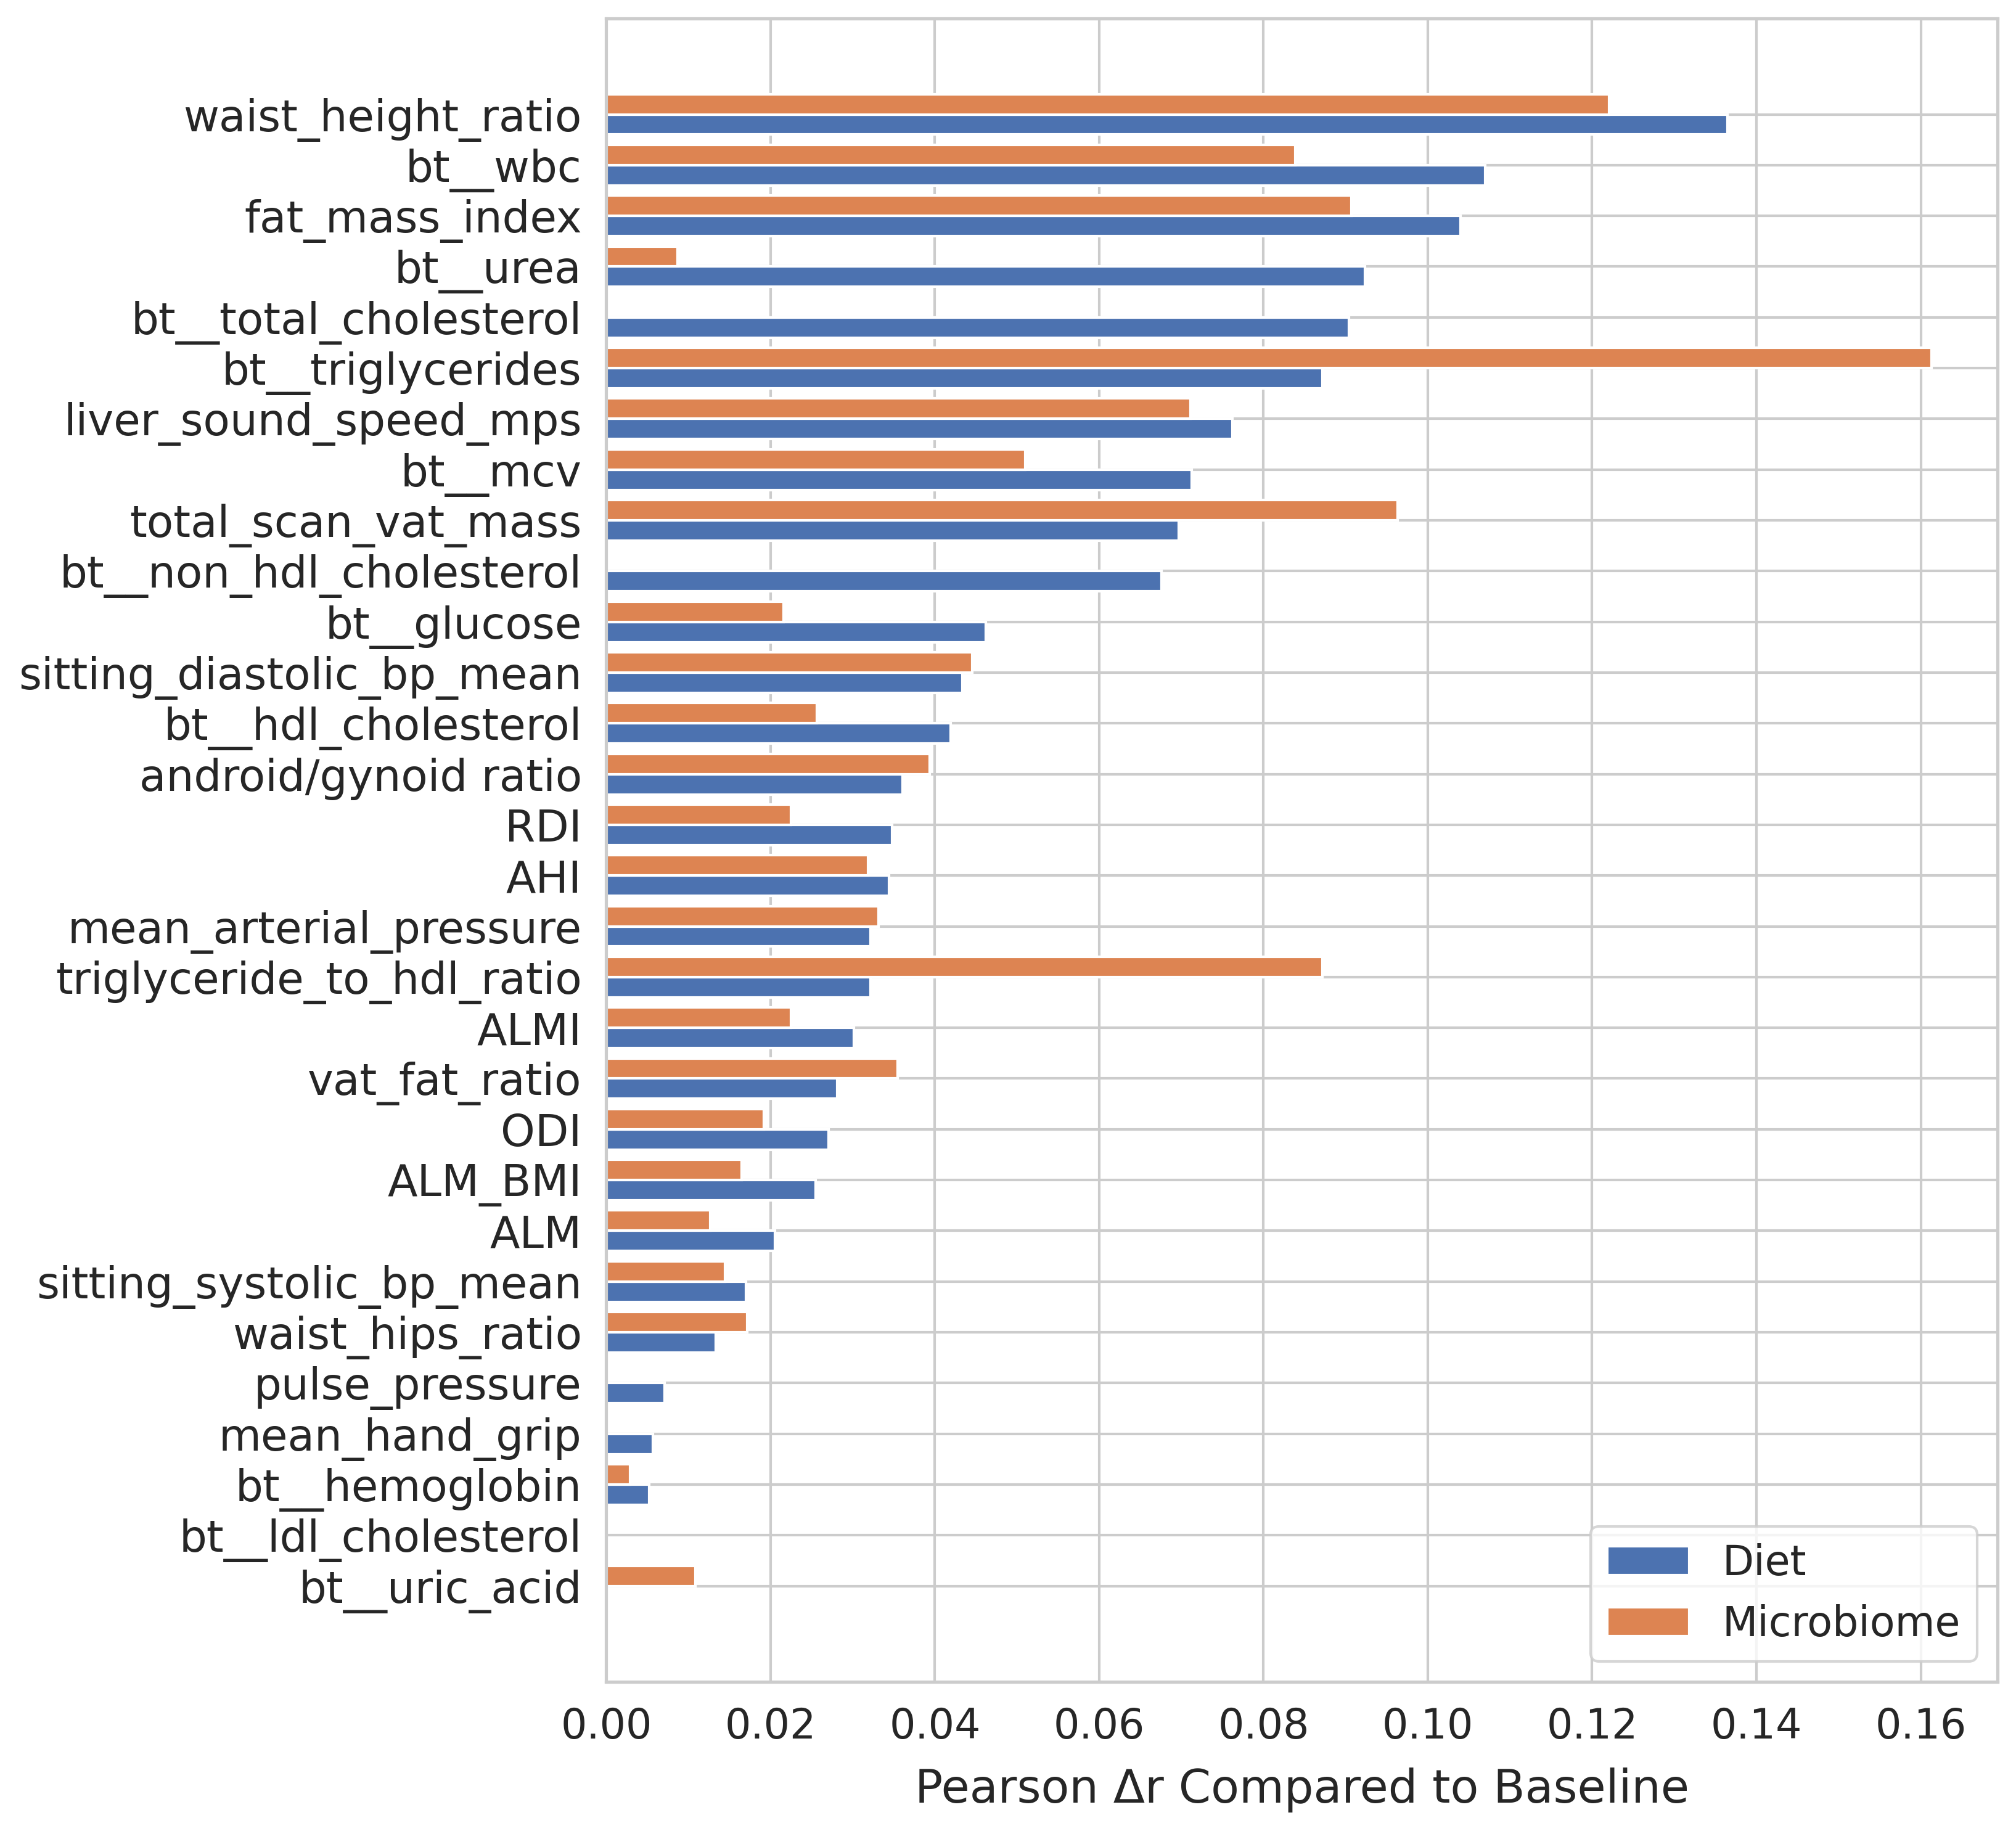

In [18]:
# Plot both delta_r_diet and delta_r_mb side by side for all targets

plt.style.use('default')              
sns.set_theme(style='whitegrid')  

# Sort by delta_r_diet for consistent visualization
diet_mb_sorted = diet_mb.sort_values("delta_r_diet", ascending=True)

# Set up the figure
plt.figure(figsize=(11, 10), dpi=300)

# Bar width and positions
bar_width = 0.4
indices = range(len(diet_mb_sorted))

# Plot bars for both groups
plt.barh(
    [i - bar_width/2 for i in indices], 
    diet_mb_sorted['delta_r_diet'], 
    height=bar_width, 
    label='Diet'
)
plt.barh(
    [i + bar_width/2 for i in indices], 
    diet_mb_sorted['delta_r_mb'], 
    height=bar_width, 
    label='Microbiome'
)

# Y-axis labels and aesthetics
plt.yticks(indices, diet_mb_sorted['target'], fontsize=17)
plt.xticks(fontsize=16)
plt.xlabel("Pearson Δr Compared to Baseline", fontsize=18, labelpad=8)
# plt.title("Predictive Gain Compared to Baseline", fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()


In [19]:
mb_results_df

,target,r_base_mb,r_combined_mb,delta_r_mb,fdr_base_mb,fdr_combined_mb
0,bt__triglycerides,0.106497,0.267772,0.161275,1.157437e-07,9.610691e-42
1,waist_height_ratio,0.241791,0.363850,0.122059,1.890529e-131,3.030435e-307
2,total_scan_vat_mass,0.449298,0.545641,0.096342,2.727273e-308,2.307692e-308
3,fat_mass_index,0.380674,0.471378,0.090704,1.656514e-240,2.307692e-308
4,triglyceride_to_hdl_ratio,0.220578,0.307754,0.087176,2.412166e-27,6.680334e-53
5,bt__wbc,0.050477,0.134335,0.083858,1.046629e-04,4.127088e-25
6,liver_sound_speed_mps,0.172496,0.243583,0.071087,2.778003e-50,4.443593e-100
7,bt__mcv,0.122912,0.173937,0.051025,2.541969e-21,2.024463e-41
8,sitting_diastolic_bp_mean,0.223441,0.267982,0.044541,9.949313e-112,1.039707e-161
9,android/gynoid ratio,0.622010,0.661362,0.039351,2.727273e-308,2.307692e-308


In [20]:
# feature_condition_mapping = {
#     # Visceral adiposity / abdominal obesity
#     'vat_fat_ratio': 'Visceral adiposity / abdominal obesity',
#     'android/gynoid ratio': 'Visceral adiposity / abdominal obesity',
#     'fat_mass_index': 'Visceral adiposity / abdominal obesity',
#     'waist_hips_ratio': 'Visceral adiposity / abdominal obesity',
#     'waist_height_ratio': 'Visceral adiposity / abdominal obesity',
#     'total_scan_vat_mass': 'Visceral adiposity / abdominal obesity',

#     # Sarcopenia
#     'mean_hand_grip': 'Sarcopenia',
#     'ALM': 'Sarcopenia',
#     'ALMI': 'Sarcopenia',
#     'ALM_BMI': 'Sarcopenia',

#     # Hypertension
#     'sitting_systolic_bp_mean': 'Hypertension',
#     'sitting_diastolic_bp_mean': 'Hypertension',
#     'pulse_pressure': 'Hypertension',
#     'mean_arterial_pressure': 'Hypertension',

#     # Fatty liver disease (MAFLD / MASLD)
#     'liver_sound_speed_mps': 'Fatty liver disease (MAFLD / MASLD)',

#     # Obstructive sleep apnea
#     'AHI': 'Obstructive sleep apnea',
#     'ODI': 'Obstructive sleep apnea',
#     'RDI': 'Obstructive sleep apnea',

#     # Impaired kidney function (CKD)
#     'bt__urea': 'Impaired kidney function (CKD)',
#     'bt__uric_acid': 'Impaired kidney function (CKD)',

#     # Increased inflammation
#     'bt__wbc': 'Increased inflammation',

#     # Impaired glucose metabolism (Prediabetes / Diabetes)
#     'bt__glucose': 'Impaired glucose metabolism (Prediabetes / Diabetes)',

#     # Anemia
#     'bt__mcv': 'Anemia',
#     'bt__hemoglobin': 'Anemia',

#     # Hyperlipidemia
#     'bt__total_cholesterol': 'Hyperlipidemia',
#     'bt__triglycerides': 'Hyperlipidemia',
#     'bt__non_hdl_cholesterol': 'Hyperlipidemia',
#     'triglyceride_to_hdl_ratio': 'Hyperlipidemia',
#     'bt__ldl_cholesterol': 'Hyperlipidemia',
#     'bt__hdl_cholesterol': 'Hyperlipidemia',
# }

# mb_results_df = mb_results_df[~mb_results_df['target'].isin(['bt__ldl_cholesterol'])]


# # Step 2: Add condition column
# mb_results_df['condition'] = mb_results_df['target'].map(feature_condition_mapping)

# # Step 3: Compute max delta_r per condition
# condition_order = (
#     mb_results_df.groupby('condition')['delta_r_mb']
#     .max()
#     .sort_values(ascending=False)
#     .index
#     .tolist()
# )

# # Step 4: Use Categorical to enforce custom order
# mb_results_df['condition'] = pd.Categorical(mb_results_df['condition'], categories=condition_order, ordered=True)

# # Step 5: Sort final dataframe
# mb_results_df = mb_results_df.sort_values(by=['condition', 'delta_r_mb'], ascending=[True, False])

# mb_results_df.style.format({
#     'r_base': '{:.2f}',
#     'r_combined': '{:.2f}',
#     'delta_r': '{:.2f}',
#     'fdr_base': '{:.1e}',
#     'fdr_combined': '{:.1e}'
# })

feature_condition_mapping = {
    # Visceral adiposity / abdominal obesity
    'vat_fat_ratio': 'Visceral adiposity / abdominal obesity',
    'android/gynoid ratio': 'Visceral adiposity / abdominal obesity',
    'fat_mass_index': 'Visceral adiposity / abdominal obesity',
    'waist_hips_ratio': 'Visceral adiposity / abdominal obesity',
    'waist_height_ratio': 'Visceral adiposity / abdominal obesity',
    'total_scan_vat_mass': 'Visceral adiposity / abdominal obesity',

    # Sarcopenia
    'mean_hand_grip': 'Sarcopenia',
    'ALM': 'Sarcopenia',
    'ALMI': 'Sarcopenia',
    'ALM_BMI': 'Sarcopenia',

    # Hypertension
    'sitting_systolic_bp_mean': 'Hypertension',
    'sitting_diastolic_bp_mean': 'Hypertension',
    'pulse_pressure': 'Hypertension',
    'mean_arterial_pressure': 'Hypertension',

    # Fatty liver disease (MAFLD / MASLD)
    'liver_sound_speed_mps': 'Fatty liver disease (MAFLD / MASLD)',

    # Obstructive sleep apnea
    'AHI': 'Obstructive sleep apnea',
    'ODI': 'Obstructive sleep apnea',
    'RDI': 'Obstructive sleep apnea',

    # Impaired kidney function (CKD)
    'bt__urea': 'Impaired kidney function (CKD)',
    'bt__uric_acid': 'Impaired kidney function (CKD)',

    # Increased inflammation
    'bt__wbc': 'Increased inflammation',

    # Impaired glucose metabolism (Prediabetes / Diabetes)
    'bt__glucose': 'Impaired glucose metabolism (Prediabetes / Diabetes)',

    # Anemia
    'bt__mcv': 'Anemia',
    'bt__hemoglobin': 'Anemia',

    # Hyperlipidemia
    'bt__total_cholesterol': 'Hyperlipidemia',
    'bt__triglycerides': 'Hyperlipidemia',
    'bt__non_hdl_cholesterol': 'Hyperlipidemia',
    'triglyceride_to_hdl_ratio': 'Hyperlipidemia',
    'bt__ldl_cholesterol': 'Hyperlipidemia',
    'bt__hdl_cholesterol': 'Hyperlipidemia',
}

# Step 1: Remove excluded targets
mb_results_df = mb_results_df[~mb_results_df['target'].isin(['bt__ldl_cholesterol'])]

# Step 2: Add condition column
mb_results_df['condition'] = mb_results_df['target'].map(feature_condition_mapping)

# Optional: Filter for significant combined model (FDR < 0.05)
mb_results_df = mb_results_df[mb_results_df['fdr_combined_mb'] < 0.05]

# Step 3: Compute max delta_r per condition
condition_order = (
    mb_results_df.groupby('condition')['delta_r_mb']
    .max()
    .sort_values(ascending=False)
    .index
    .tolist()
)

# Step 4: Use Categorical to enforce custom order
mb_results_df['condition'] = pd.Categorical(mb_results_df['condition'], categories=condition_order, ordered=True)

# Step 5: Sort final dataframe
mb_results_df = mb_results_df.sort_values(by=['condition', 'delta_r_mb'], ascending=[True, False])

# Step 6: Format for display
mb_results_df.style.format({
    'r_base_mb': '{:.2f}',
    'r_combined_mb': '{:.2f}',
    'delta_r_mb': '{:.2f}',
    'fdr_base_mb': '{:.1e}',
    'fdr_combined_mb': '{:.1e}'
})


/usr/wisdom/python3/lib/python3.7/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,target,r_base_mb,r_combined_mb,delta_r_mb,fdr_base_mb,fdr_combined_mb,condition
0,bt__triglycerides,0.11,0.27,0.16,1.2e-07,9.6e-42,Hyperlipidemia
4,triglyceride_to_hdl_ratio,0.22,0.31,0.09,2.4e-27,6.7e-53,Hyperlipidemia
13,bt__hdl_cholesterol,0.40,0.43,0.03,8.6e-96,1.5e-109,Hyperlipidemia
27,bt__non_hdl_cholesterol,0.18,0.16,0.00,1.9e-18,1.1e-15,Hyperlipidemia
28,bt__total_cholesterol,0.24,0.20,0.00,8.1e-34,1.1e-23,Hyperlipidemia
1,waist_height_ratio,0.24,0.36,0.12,1.9e-131,3.0e-307,Visceral adiposity / abdominal obesity
2,total_scan_vat_mass,0.45,0.55,0.10,2.7e-308,2.3e-308,Visceral adiposity / abdominal obesity
3,fat_mass_index,0.38,0.47,0.09,1.7e-240,2.3e-308,Visceral adiposity / abdominal obesity
9,android/gynoid ratio,0.62,0.66,0.04,2.7e-308,2.3e-308,Visceral adiposity / abdominal obesity
10,vat_fat_ratio,0.66,0.69,0.04,2.7e-308,2.3e-308,Visceral adiposity / abdominal obesity


Dumbell plot

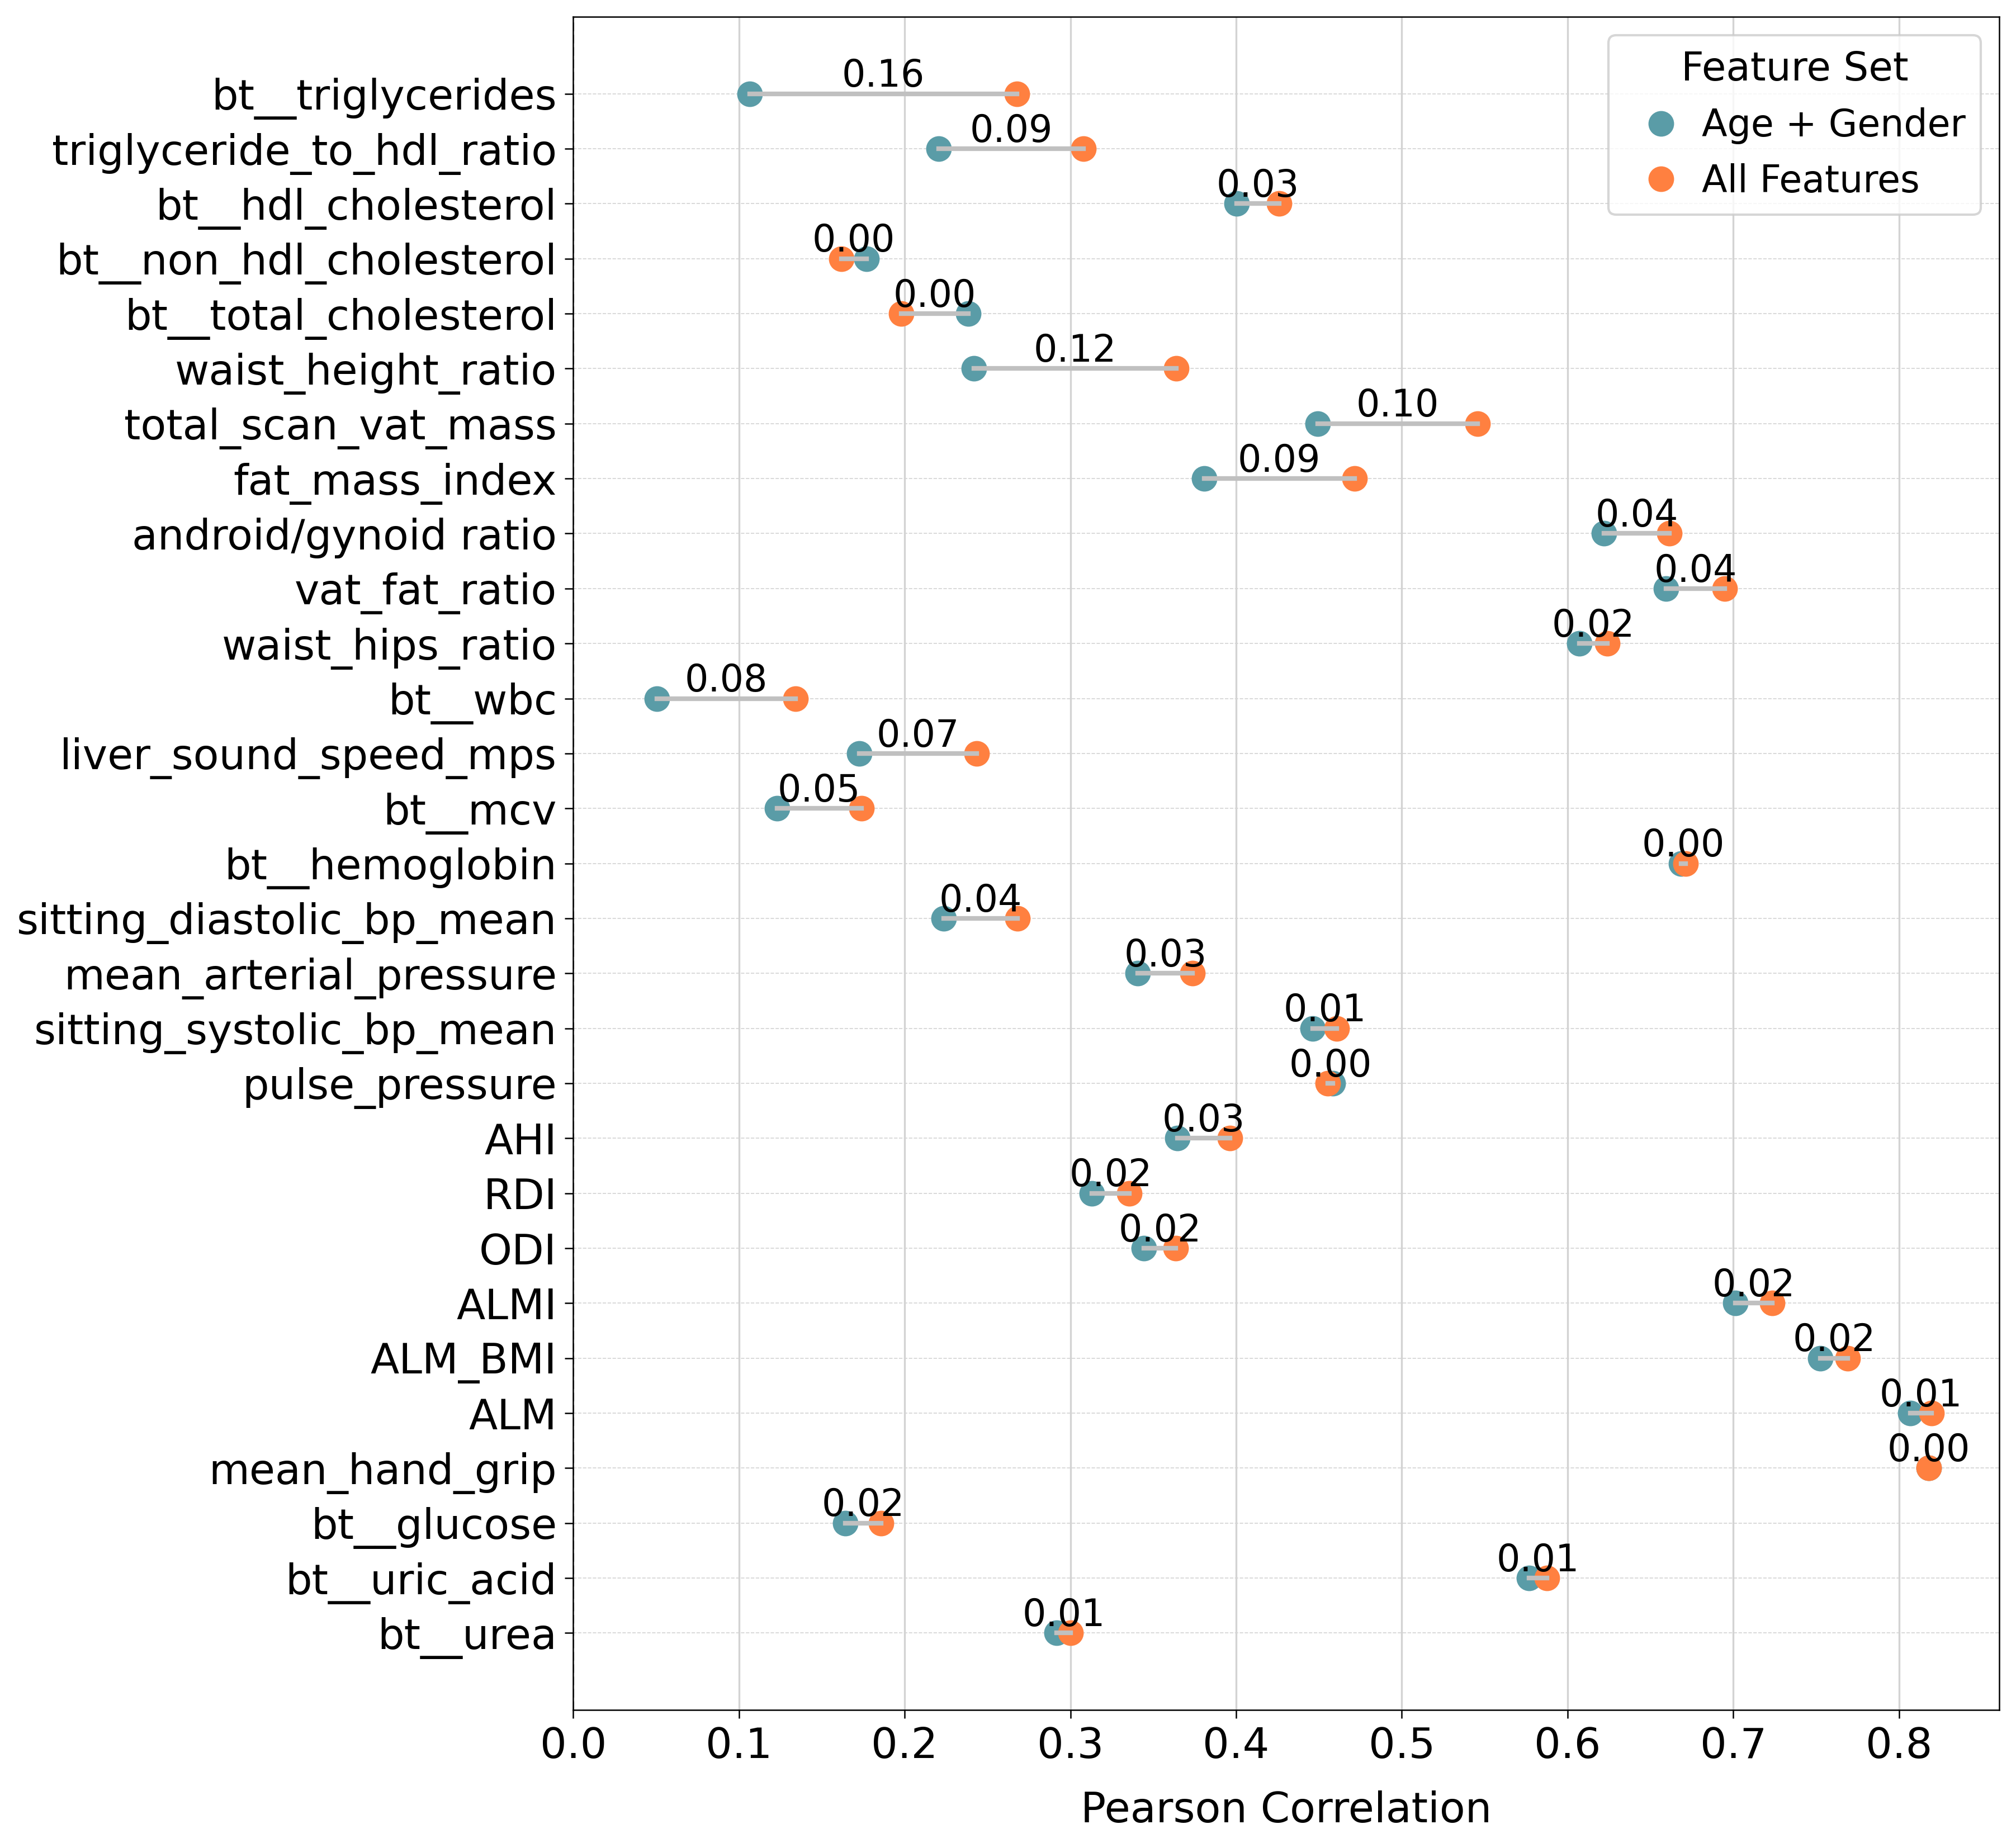

In [30]:
# Sort by delta_r ascending (smallest gain at top)
yticks = list(mb_results_df['target'])[::-1]

# Apply spacing
spacing = 200
ypos = [i * spacing for i in range(len(yticks))]

# Create plot
plt.figure(figsize=(12, 11), dpi=300)

for i, feature in enumerate(yticks):
    row = mb_results_df[mb_results_df['target'] == feature].iloc[0]
    delta_r = row['delta_r_mb']
    y = ypos[i]

    # Line connecting base → combined
    plt.plot(
        [row['r_base_mb'], row['r_combined_mb']],
        [y, y],
        color='silver', lw=2
    )
    # Baseline marker (circle)
    plt.scatter(row['r_base_mb'], y, color='#5A9CA7', marker='o', s=100)
    # Combined marker (diamond)
    plt.scatter(row['r_combined_mb'], y, color='#FF8040', marker='o', s=100)

    # Δr label above line
    mid_x = (row['r_base_mb'] + row['r_combined_mb']) / 2
    plt.text(mid_x, y + 25, f"{delta_r:.2f}", ha='center', fontsize=16, color='black')

# Axes and grid
plt.yticks(ticks=ypos, labels=yticks, fontsize=18)
plt.xticks(fontsize=18)
plt.axvline(0, color='gray', linestyle='--', lw=1)
plt.xlabel('Pearson Correlation', fontsize=18, labelpad=10)
plt.xlim(left=0)
# plt.title('Microbiome Predictive Gain Compared to Baseline', fontsize=14)
plt.grid(False)

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='#5A9CA7', label='Age + Gender', markersize=10, linestyle='None'),
    Line2D([0], [0], marker='o', color='#FF8040', label='All Features', markersize=10, linestyle='None'),
]
plt.legend(
    handles=legend_elements,
    title='Feature Set',
    loc='upper right',
    bbox_to_anchor=(1.0, 1.0),
    frameon=True,
    fontsize=16,
    title_fontsize=17,
    handletextpad=0.1
)

# Add vertical lines at each x-tick, except 0
for xtick in plt.xticks()[0]:
    if xtick == 0:
        continue  # Skip 0 to avoid duplicate line
    plt.axvline(x=xtick, color='lightgray', linestyle='-', linewidth=0.8, zorder=0)

for y in ypos:
    plt.axhline(y=y, color='lightgray', linestyle='--', linewidth=0.4, zorder=0)
   
plt.tight_layout()

# Style
plt.style.use('default')              
sns.set_theme(style='whitegrid')      

# Save and show
plt.savefig('/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/delta_r_microbiome_vs_age_gender.png', dpi=300)
plt.show()

Nature style

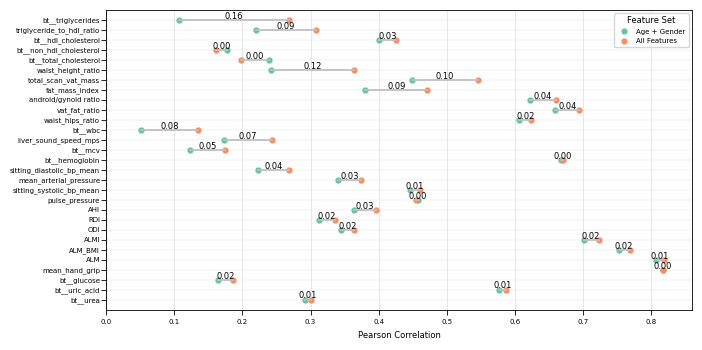

In [106]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm

# Reset first
mpl.rcParams.update(mpl.rcParamsDefault)

# Apply Nature style (must be last)
double_style = "nature_double.mplstyle"
single_style = "nature_single.mplstyle"
plt.style.use(double_style)

# Set2 palette (8 distinct colors)
set2 = cm.get_cmap("Set2").colors
color_base = set2[0]      # Age + Gender
color_combined = set2[1]  # All Features

# -----------------------------
# Sort by delta_r ascending (smallest gain at top)
yticks = list(mb_results_df['target'])[::-1]

# Apply spacing
spacing = 200
ypos = [i * spacing for i in range(len(yticks))]

# Create plot (figsize/dpi taken from style file)
# fig, ax = plt.subplots(figsize=(3.5, 0.12 * len(yticks)))  # 0.35 can be tuned

# Get default width from the style
default_width, default_height = plt.rcParams["figure.figsize"]

# Override only the height
fig, ax = plt.subplots(figsize=(default_width, 0.12 * len(yticks)))


for i, feature in enumerate(yticks):
    row = mb_results_df[mb_results_df['target'] == feature].iloc[0]
    delta_r = row['delta_r_mb']
    y = ypos[i]

    # Line connecting base → combined
    ax.plot(
        [row['r_base_mb'], row['r_combined_mb']],
        [y, y],
        color='silver',
        linewidth=1.3
    )
    # Baseline marker (circle)
    ax.scatter(row['r_base_mb'], y, color=color_base, marker='o')
    # Combined marker (circle)
    ax.scatter(row['r_combined_mb'], y, color=color_combined, marker='o')

    # Δr label above line (no manual fontsize override)
    mid_x = (row['r_base_mb'] + row['r_combined_mb']) / 2
    ax.text(mid_x, y + 25, f"{delta_r:.2f}", ha='center', color='black')

# Axes and grid (let style handle fonts/ticks)
ax.set_yticks(ypos)
ax.set_yticklabels(yticks)
ax.tick_params(axis="y", pad=1)   # smaller = closer to the axis
ax.axvline(0, color='gray', linestyle='--')
ax.set_xlabel('Pearson Correlation')
ax.set_ylim(-spacing, max(ypos) + spacing)
ax.set_xlim(left=0)
ax.grid(False)

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color=color_base, label='Age + Gender',
            linestyle='None'),
    Line2D([0], [0], marker='o', color=color_combined, label='All Features',
            linestyle='None'),
]
ax.legend(
    handles=legend_elements,
    title='Feature Set',
    loc='upper right',
    bbox_to_anchor=(1.0, 1.0),
    frameon=True
)
    

# Add vertical lines at each x-tick, except 0
for xtick in ax.get_xticks():
    if xtick == 0:
        continue
    ax.axvline(x=xtick, color='lightgray', linestyle='-', linewidth=0.4, zorder=0)

# Add horizontal reference lines
for y in ypos:
    ax.axhline(y=y, color='lightgray', linestyle='-', linewidth=0.2, zorder=0)

fig.tight_layout()

# Save and show
fig.savefig(
    '/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/delta_r_microbiome_vs_age_gender.png'
)
plt.show()
